## Introduction
The purpose of this notebook is to quickly train a image classifier that is able to distinguish between images of cats and dogs and achieve some acceptable degree of performance (a binary classification problem). Accuracy will be used to evaluate the performance and we'll train a simple CNN to classify the images.

In order to make this notebook neat, some helper functions are defined in the [utils.py](utils.py), feel free to check it out when you want to dig deeper.

## Libraries

In [ ]:
import os
import tensorflow as tf
from utils import *

jupyter notebook magic functions 
- render graph directly without ```plt.show()```
- to reload the external python script whenever there are changes.

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Dataset preparation
The image data we're going to use is [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on [Kaggle](https://www.kaggle.com/) which contain 25,000 images of dogs and cats. You may need a Kaggle account to download the dataset on your local machine. The training set and test set  will be stored under ```datasets/train``` and ```datasets/test1``` subdirectories respectively.

In [ ]:
TRAIN_DIR = 'datasets/train/'
TEST_DIR = 'datasets/test1'
print("Number of training images: {}".format(len(os.listdir(TRAIN_DIR))))
print("Number of test images: {}".format(len(os.listdir(TEST_DIR))))

Number of training images: 25000
Number of test images: 12500


### Load the dataset and resize the images
The dataset will include two parts:
- X: the actual images transformed to ndarray with shape of ```(#images, height, width, #channels)```
- y: corresponding labels, where ```label = 0``` for dog images and ```label = 1``` for cat images.

Notice that there are 25,000 images in total available for training, but we will just use a subset of it like 5,000 images to speed up training phase. Also resize the images' height and width to 64 to make our model simpler.

In [ ]:
dataset_size = 20000
image_size = 64

In [ ]:
%%time
X, y = load_image_dataset(dataset_size=dataset_size, size=(image_size, image_size))
print(X.shape, y.shape)

(20000, 64, 64, 3) (20000, 1)
CPU times: user 2min 7s, sys: 3.16 s, total: 2min 10s
Wall time: 2min 22s


### Inspect images in the dataset

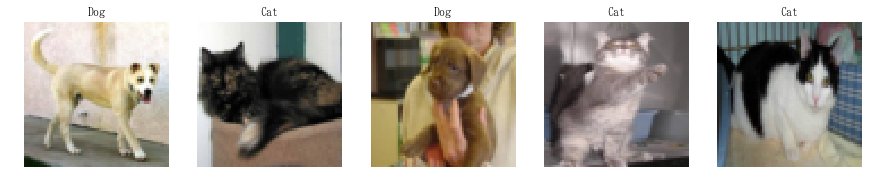

In [ ]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Normalization
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to **center and standardize** your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for **picture** datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [ ]:
%%time
X = X / 255

CPU times: user 904 ms, sys: 578 ms, total: 1.48 s
Wall time: 1.59 s


Although there seems no difference in human eyes after normlization.

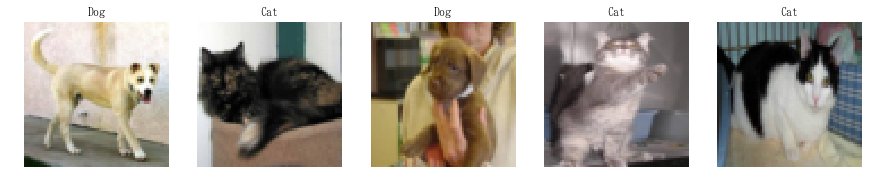

In [ ]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Build training / validation set
It's a good practice to make a subset of dataset as validation set and tuning our models before actually test their performance on the test set. Because the order of images in the dataset are already randomized (by randomly pick images in the folder), we can just separate the dataset into training set / validation set in the ratio of (0.9, 0.1) without further shuffling.

In [ ]:
train_set_ratio = 0.9
threshold = 500
idx = int(dataset_size * train_set_ratio)
valid_set_size = X.shape[0] - idx
idx = X.shape[0] - threshold if valid_set_size > threshold else idx
train_X, train_y, valid_X, valid_y = X[:idx], y[:idx], X[idx:], y[idx:]
del X, y # tips to save memory

Training set: (19500, 64, 64, 3), (19500, 1)
Validation set: (500, 64, 64, 3), (500, 1)
Some images in validation set:


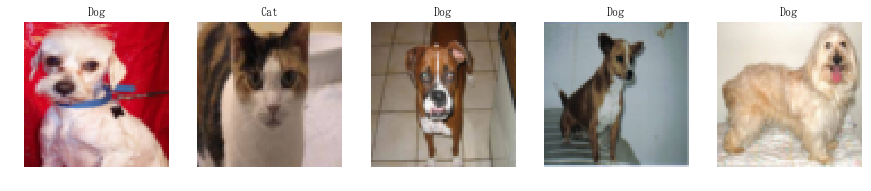

In [ ]:
print('Training set: {}, {}'.format(train_X.shape, train_y.shape))
print('Validation set: {}, {}'.format(valid_X.shape, valid_y.shape))
print('Some images in validation set:')
show_images_horizontally(valid_X[:num_samples], valid_y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Class distribution in dataset
Make sure the distribution of training/validation set are similar and there is no serious unbalanced class problem. In this dataset, there are only two classes: cats and dogs, so it will be prefect that the dataset consist of about 50% of dogs and cats, respectively.

In [ ]:
train_cat, valid_cat = train_y == 1, valid_y == 1
print('{:.1f}% images in training set are cats'.format(len(train_y[train_cat]) / len(train_y) * 100))
print('{:.1f}% images in validation set are cats'.format(len(valid_y[valid_cat]) / len(valid_y) * 100))

49.9% images in training set are cats
48.2% images in validation set are cats


Seems that we're good to go.

## Build the classifier
For the binary classification we're facing (for any image, whether it's a cat image or dog image), we will use a simple convoluational neural network with two convolational layers followed by a fully connected layer. In terms of regularization, we will use dropout between conv and fully-connected layer.

### Hyper parameters

In [ ]:
batch_size = 16
patch_size = 5
input_depth = 3
output_depth = 16
num_hidden = 16
keep_prob = 0.5

### Define evaluation metric

In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum((predictions > 0.5).astype(float) == labels)\
            / predictions.shape[0])


### Computation graph
After instruct our model how to do forward prop, TensorFlow will do the back prop for us automatically.
Some tips here:
- make sure to name every tensor for easier reference later
- create tensors designed for single image prediction: ```tf_new_X``` and ```tf_new_y```
- set keep_prob of dropout to 1 when making prediction

In [ ]:
graph = tf.Graph()

with graph.as_default():
    # input of every mini-batch training data
    tf_train_X = tf.placeholder(tf.float32, name='tf_train_X',
        shape=(batch_size, image_size, image_size, input_depth))
    tf_train_y = tf.placeholder(tf.float32, name='tf_train_y', 
        shape=(batch_size, 1))
    
    # input for every single realtime prediction
    tf_new_X = tf.placeholder(tf.float32, name='tf_new_X',
        shape=(1, image_size, image_size, input_depth))
    tf_new_y = tf.placeholder(tf.float32, name='tf_new_y',
        shape=(1, 1))
    
    # use entire validation set to evaluate model
    tf_valid_X = tf.constant(valid_X.astype('float32'),
        name='tf_valid_X')
    
    # turn off dropout regularization when predict and allow
    # adjustment when training
    tf_keep_prob_train = tf.placeholder_with_default(1.0, name='tf_keep_prob_train',
        shape=())
    tf_keep_prob_valid = tf.constant(1.0, name='tf_keep_prob_valid',
        shape=())

    # define parameters(weights / biases) when init: 
    # When defining weights for a convoluational layer, use the notation
    # [filter_size, filter_size, input_depth, output_depth]
    layer1_weights = tf.Variable(
        tf.truncated_normal(
            [patch_size, patch_size, input_depth, output_depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([output_depth]))
    
    # in this CNN, two convoluational layers happen to have the same depth.
    # if we want, we can adjust them to be different like depth1, depth2
    layer2_weights = tf.Variable(
        tf.truncated_normal(
            [patch_size, patch_size, output_depth, output_depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[output_depth]))
    
    
    # because we use stride = 2 and SAME padding, our new shape of first feature map C1
    # will be (image_size // 2, image_size //2). and because we use 2 convolutional layers,
    # the shape of second feature map C2 will be (image_size // 2 // 2, image_size // 2 // 2)
    # = (image_size // 4, image_size // 4). and because we have output_depth == 16,
    # the total neurons on C2 will be image_size // 4 * image_size // 4 * depth
    layer3_weights = tf.Variable(
        tf.truncated_normal(
            [image_size // 4 * image_size // 4 * output_depth, num_hidden],
            stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, 1], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[1]))

    # Model.
    def model(data, keep_prob):
        # this is where we set stride = 2 for both width and height and also SAME padding
        # the third parameters in tf.nn.conv2d is to set stride for every dimension
        # specified in the first parameter data's shape
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(
            hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        
        # turn the C2 3D cube back to 2D matrix by shape (#data_points, #neurons)
        reshape = tf.reshape(hidden,
            [shape[0], shape[1] * shape[2] * shape[3]])
        dropout = tf.nn.dropout(reshape, keep_prob)
        hidden = tf.nn.relu(tf.matmul(dropout, layer3_weights) + layer3_biases)
#         hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_X, tf_keep_prob_train)
    loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf_train_y, logits=logits), name='loss')

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation set and realtime prediction
    tf_train_y_pred = tf.nn.sigmoid(logits, name='tf_train_y_pred')
    tf_valid_y_pred = tf.nn.sigmoid(model(tf_valid_X, tf_keep_prob_valid), name='tf_valid_y_pred')
    tf_new_y_pred = tf.nn.sigmoid(model(tf_new_X, tf_keep_prob_valid), name='tf_new_y_pred')
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

### Train and serialize model
We will use mini-batch GD to train our model. After finish training, save the trained model for later usage.

Tips:
- set keep_prob of dropout regularization to 0.5 when training

In [ ]:
save_path = 'models/model.ckpt'


In [ ]:
%%time
num_steps = 10001
step_interval = 500

with tf.Session(graph=graph) as sess:
    # initialize weights
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        # get new mini-batch for training
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        # enable dropout regularization when training
        feed_dict = {
            tf_train_X: batch_X,
            tf_train_y: batch_y,
            tf_keep_prob_train: 0.5
        }
        _, l, batch_y_pred = sess.run(
            [optimizer, loss, tf_train_y_pred], feed_dict=feed_dict)
        
        # output loss and accuracy while training
        if (step % step_interval == 0):
            print('Minibatch loss at step {}: {:.3f}.'.format(step, l) +
                  'batch acc: {:.1f}%, Valid acc: {:.1f}%.'\
                  .format(accuracy(batch_y_pred, batch_y),
                          accuracy(tf_valid_y_pred.eval(), valid_y)))
            
    # final prediction for validation set
    vaild_y_pred_before_restore = tf_valid_y_pred.eval()
    
    
    # Save the variables to disk.
    save_path = saver.save(sess, save_path)
    print("Model saved in file: %s" % save_path)

Minibatch loss at step 0: 1.460.batch acc: 37.5%, Valid acc: 48.2%.
Minibatch loss at step 500: 0.768.batch acc: 43.8%, Valid acc: 57.6%.
Minibatch loss at step 1000: 0.738.batch acc: 56.2%, Valid acc: 55.0%.
Minibatch loss at step 1500: 0.671.batch acc: 56.2%, Valid acc: 58.4%.
Minibatch loss at step 2000: 0.688.batch acc: 62.5%, Valid acc: 59.2%.
Minibatch loss at step 2500: 0.801.batch acc: 37.5%, Valid acc: 61.0%.
Minibatch loss at step 3000: 0.747.batch acc: 50.0%, Valid acc: 57.0%.
Minibatch loss at step 3500: 0.777.batch acc: 50.0%, Valid acc: 60.6%.
Minibatch loss at step 4000: 0.643.batch acc: 75.0%, Valid acc: 62.8%.
Minibatch loss at step 4500: 0.648.batch acc: 50.0%, Valid acc: 60.4%.
Minibatch loss at step 5000: 0.588.batch acc: 62.5%, Valid acc: 63.4%.
Minibatch loss at step 5500: 0.676.batch acc: 62.5%, Valid acc: 58.8%.
Minibatch loss at step 6000: 0.513.batch acc: 75.0%, Valid acc: 67.6%.
Minibatch loss at step 6500: 0.465.batch acc: 75.0%, Valid acc: 67.2%.
Minibatch 

Although the performance can be further improved, as our goal is to train a simple model and deploy it, we will just leave it here and take a look where did the model make the mistake on validation set.


## Show some mis-classified images

Get indices of mis-classified images in validation set

In [ ]:
mislabeled_indices = []
for idx, (i, j) in enumerate(zip(vaild_y_pred_before_restore.reshape(-1, 1), valid_y.reshape(-1, 1))):
    prob, label = i[0], j[0]
    label_pred = 1 if prob > 0.5 else 0
    if label_pred != label: mislabeled_indices.append(idx)
print('{}% of images are mis-classified in validation set.'\
      .format(len(mislabeled_indices) / valid_y.shape[0] * 100))

29.599999999999998% of images are mis-classified in validation set.


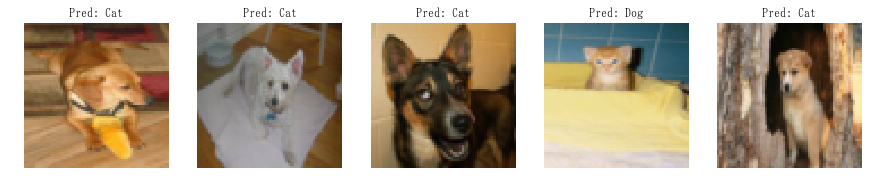

In [ ]:
samples = np.random.choice(mislabeled_indices, 5)
show_images_horizontally(valid_X[samples], valid_y[samples], figsize=(15, 10),
                         lookup_label={0: 'Pred: Cat', 1: 'Pred: Dog'})


## Real time prediction simulation
Upon now, we already trained a model that is ready to be deploy! Let's load the model we saved earlier and see whether we can generate the same prediction result on validation set using the loaded model.

If there is any error in this part, try to restart kernel and run all the code again.


In [ ]:
meta_path = 'models/model.ckpt.meta'


### Load the model and make prediction on validation set

In [ ]:
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.

with tf.Session() as sess:
    
    # Restore variables from disk.
    new_saver = tf.train.import_meta_graph(meta_path)
    new_saver.restore(sess, save_path)
    print("Model restored.")
    
    #Now, access the op that you want to run. 
    graph = tf.get_default_graph()
    tf_new_X = graph.get_tensor_by_name("tf_new_X:0")
    tf_new_y = graph.get_tensor_by_name("tf_new_y:0")
    tf_new_y_pred = graph.get_tensor_by_name("tf_new_y_pred:0")

    feed_dict = {
        tf_new_X: valid_X[:1],
        tf_new_y: valid_y[:1]
    }

    new_y_pred = sess.run(
            [tf_new_y_pred], feed_dict=feed_dict)
    
    tf_valid_y_pred = graph.get_tensor_by_name("tf_valid_y_pred:0")

    vaild_y_pred_after_restore = tf_valid_y_pred.eval()


INFO:tensorflow:Restoring parameters from models/model.ckpt
Model restored.


### Sanity check 
Compare prediction result on validation before/after model restoration to make sure we got the right model.

In [ ]:
assert(np.all(vaild_y_pred_before_restore==vaild_y_pred_after_restore))
print("Loaded model's prediction on validation is exactly the same as expected.")


Loaded model's prediction on validation is exactly the same as expected.


## Summary
In next step, we will deploy this model and try to build a ML application.